# Task 4

In [1]:
import numpy as np
from CartPol2 import *
from sklearn import linear_model
import time
import itertools
from textwrap import wrap
import scipy

In [2]:
    def start_the_cart(initial_values1, initial_values2=None, initial_values3=None, steps=10, remap_angle=False, visual=False, display_plots=True, variable = None):

        cp = CartPole(visual=visual)
        cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity,force = initial_values1
        
        

        for step in range(steps):
            if visual: 
                cp.drawPlot()
            cp.performAction(action=force)
            if remap_angle: 
                cp.remap_angle()
            inter= [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
            try: 
                x_history = np.vstack((x_history, np.array(inter)))
            except:
                x_history = np.vstack((np.array(initial_values1[:4]),np.array(inter)))
        

        
        x_axis=range(len(x_history))
        
        if initial_values2:
            cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity,force  = initial_values2
        
           

            for step in range(steps):
                if visual: cp.drawPlot()
                cp.performAction(action=force)
                if remap_angle: cp.remap_angle()
                inter= [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
                try: 
                    y_history = np.vstack((y_history, np.array(inter)))
                except:
                    y_history = np.vstack((np.array(initial_values2[:4]),np.array(inter)))
        
        if initial_values3:
            cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity,force = initial_values3
        
            

            for step in range(steps):
                if visual: cp.drawPlot()
                cp.performAction(action=force)
                if remap_angle: cp.remap_angle()
                inter= [cp.cart_location, cp.cart_velocity, cp.pole_angle, cp.pole_velocity]
                try: 
                    z_history = np.vstack((z_history, np.array(inter)))
                except:
                    z_history = np.vstack((np.array(initial_values3[:4]),np.array(inter)))
        
        if display_plots:
            fig, axs = plt.subplots(2, 2, figsize=(10, 7))

            axs[0,0].plot(x_axis, [x[0] for x in x_history],label='First')
            if initial_values2: axs[0,0].plot(x_axis, [x[0] for x in y_history],label='Second')
            if initial_values3: axs[0,0].plot(x_axis, [x[0] for x in z_history],label='Third')

            axs[0,1].plot(x_axis, [x[1] for x in x_history])
            if initial_values2: axs[0,1].plot(x_axis, [x[1] for x in y_history])
            if initial_values3: axs[0,1].plot(x_axis, [x[1] for x in z_history])
           
            axs[1,0].plot(x_axis, [x[2] for x in x_history])
            if initial_values2: axs[1,0].plot(x_axis, [x[2] for x in y_history])
            if initial_values3: axs[1,0].plot(x_axis, [x[2] for x in z_history])
            
            axs[1,1].plot(x_axis, [x[3] for x in x_history])
            if initial_values2: axs[1,1].plot(x_axis, [x[3] for x in y_history])
            if initial_values3: axs[1,1].plot(x_axis, [x[3] for x in z_history])
            
            #Set titles
            axs[0,0].set_title('Cart location')
            axs[0,0].set_xlabel('Steps')
            axs[0,0].set_ylabel('x')

            axs[0,1].set_title('Cart velocity')
            axs[0,1].set_xlabel('Steps')
            axs[0,1].set_ylabel('x_dot')


            axs[1,0].set_title('Pole angle')
            axs[1,0].set_xlabel('Steps')
            axs[1,0].set_ylabel('theta')

            axs[1,1].set_title('Pole velocity')
            axs[1,1].set_xlabel('Steps')
            axs[1,1].set_ylabel('theta_dot')

            if variable: fig.suptitle(('Effect of different initial {} on cart dynamics').format(variable),fontsize=16)

            fig.legend()
            fig.tight_layout()
        
        
        return x_history

In [3]:
variable_number={0:'Cart location',1:'Cart velocity',2:'Pole angle',3:'Pole velocity',4:'Force'}

In [4]:
def remap(theta):
    while theta < -np.pi:
        theta += 2. * np.pi
    while theta > np.pi:
        theta -= 2. * np.pi
    return theta

In [5]:
def loss3(state):
    sig1=[3,3,3,3]
    sig2=[1,0.8,0.8,0.75]
    sig3=[1,0.5,0.5,0.6]
    sig4=[1,0.3,0.3,0.3]

    first = 1-np.exp(-np.dot(state/sig1,state/sig1)/(2.0))
    second = 1-np.exp(-np.dot(state/sig2,state/sig2)/(2.0))
    third = 1-np.exp(-np.dot(state/sig3,state/sig3)/(2.0))
    fourth = 1-np.exp(-np.dot(state/sig4,state/sig4)/(2.0))

    return first,second,third,fourth


# Task 4 begins

In [175]:
def non_lin_policy(X,X_i,w_i,matrix,basis):
    assert basis == X_i.shape[0]
    assert basis == w_i.shape[0]
    policy=0
    for i in range(basis):
        bracket= np.array(X)-np.array(X_i[i])
        power=np.matmul(bracket.T,np.matmul(matrix,bracket))
        exponent=np.exp(-0.5*power)
        policy+= w_i[i]*exponent
    return 20 * np.tanh(policy/20)

In [241]:
def f5(params,initial_list,basis):
    #print(started_iteration)
    
    w1,w2,w3,w4,w5 = params[:basis]
    #,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
    x1=np.array(params[basis:basis+4])
    x2=np.array(params[basis+4:basis+8])
    x3=np.array(params[basis+8:basis+12])
    x4=np.array(params[basis+12:basis+16])
    x5=np.array(params[basis+16:basis+20])

    
    m11,m12,m13,m14,m22,m23,m24,m33,m34,m44=params[basis+20:]

   

    mat = np.array( [[m11,m12,m13,m14],
                    [m12,m22,m23,m24],
                    [m13,m23,m33,m34],
                    [m14,m24,m34,m44]])

    w = np.array([w1,w2,w3,w4,w5])

    loss_p=0
    
    X_i=np.array([x1,x2,x3,x4,x5])
    
    steps=20
    for initials in initial_list:
        x_=initials.copy()
        for step in range(steps):
            y_ = np.array(start_the_cart(x_, steps=1, display_plots=False, visual=False,remap_angle=False)[-1])
            
            #loss_p+= loss(y_)
            
            
            if step<=steps*0.25:loss_p+= loss3(y_)[0]
            elif step>steps*0.25 and step<=steps*0.5: loss_p+= loss3(y_)[1]
            elif step>steps*0.5 and step<=steps*0.75: loss_p+= loss3(y_)[2]
            elif step>steps*0.75: loss_p+= loss3(y_)[3]
            
            #print(w)
            p=non_lin_policy(y_,X_i,w,mat,basis=basis)
            action_=p
            
            #action_ = 20 * np.tanh(action_/20)
            y_=np.append(y_,action_)
            
            x_=y_.copy()
    print(loss_p)
    return loss_p

In [242]:
def f10(params,initial_list,basis):
    #print(started_iteration)
    
    w1,w2,w3,w4,w5,w6,w7,w8,w9,w10 = params[:basis]
    #,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
    x1=np.array(params[basis:basis+4])
    x2=np.array(params[basis+4:basis+8])
    x3=np.array(params[basis+8:basis+12])
    x4=np.array(params[basis+12:basis+16])
    x5=np.array(params[basis+16:basis+20])
    
    x6=np.array(params[basis+20:basis+24])
    x7=np.array(params[basis+24:basis+28])
    x8=np.array(params[basis+28:basis+32])
    x9=np.array(params[basis+32:basis+36])
    x10=np.array(params[basis+36:basis+40])
    """
    x11=np.array(params[basis+40:basis+44])
    x12=np.array(params[basis+44:basis+48])
    x13=np.array(params[basis+48:basis+52])
    x14=np.array(params[basis+52:basis+56])
    x15=np.array(params[basis+56:basis+60])
    """
    
    m11,m12,m13,m14,m22,m23,m24,m33,m34,m44=params[basis+40:]

   

    mat = np.array( [[m11,m12,m13,m14],
                    [m12,m22,m23,m24],
                    [m13,m23,m33,m34],
                    [m14,m24,m34,m44]])

    w = np.array([w1,w2,w3,w4,w5,w6,w7,w8,w9,w10])

    loss_p=0
    
    X_i=np.array([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])
    
    steps=20
    for initials in initial_list:
        x_=initials.copy()
        for step in range(steps):
            y_ = np.array(start_the_cart(x_, steps=1, display_plots=False, visual=False,remap_angle=False)[-1])
            
            #loss_p+= loss(y_)
            
            
            if step<=steps*0.25:loss_p+= loss3(y_)[0]
            elif step>steps*0.25 and step<=steps*0.5: loss_p+= loss3(y_)[1]
            elif step>steps*0.5 and step<=steps*0.75: loss_p+= loss3(y_)[2]
            elif step>steps*0.75: loss_p+= loss3(y_)[3]
            
            #print(w)
            p=non_lin_policy(y_,X_i,w,mat,basis=basis)
            action_=p
            
            #action_ = 20 * np.tanh(action_/20)
            y_=np.append(y_,action_)
            
            x_=y_.copy()
    print(loss_p)
    return loss_p

In [243]:
def f2(params,initials,basis,X_i):
    #print(started_iteration)
    w1,w2,w3,w4,w5 = params[:basis]
    #,w6,w7,w8,w9,w10
    
    
    
    m11,m12,m13,m14,m22,m23,m24,m33,m34,m44=params[basis:]

   

    mat = np.array( [[m11,m12,m13,m14],
                    [m12,m22,m23,m24],
                    [m13,m23,m33,m34],
                    [m14,m24,m34,m44]])

    w = np.array([w1,w2,w3,w4,w5])

    loss_p=0
    
    
    
    steps=20
    
    x_=initials.copy()
    for step in range(steps):
        y_ = np.array(start_the_cart(x_, steps=1, display_plots=False, visual=False,remap_angle=False)[-1])
        
        #loss_p+= loss(y_)
        
        
        if step<=steps*0.25:loss_p+= loss3(y_)[0]
        elif step>steps*0.25 and step<=steps*0.5: loss_p+= loss3(y_)[1]
        elif step>steps*0.5 and step<=steps*0.75: loss_p+= loss3(y_)[2]
        elif step>steps*0.75: loss_p+= loss3(y_)[3]
        

        
        #print(w)
        p=non_lin_policy(y_,X_i,w,mat,basis=basis)
        action_=p
        
        action_ = 20 * np.tanh(action_/20)
        y_=np.append(y_,action_)
        
        x_=y_.copy()
    print(loss_p)
    return loss_p

In [234]:
X_i=np.array([[0,0,np.pi,0],[0,0,2,1],[1,0,1,1],[0,0,0.1,0],[0,0,0,0]])

In [235]:
non_lin_start=np.array([[0,0,0.1,0,0]])

In [236]:
print(non_lin_start[1])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [244]:
initial_guess=np.random.normal(0,1,35)
initial_guess2=np.random.normal(0,0.1,15)

In [245]:
print(initial_guess)

[ 0.68850857 -0.44071894  0.33251815  0.33886984 -0.5479768  -0.51948243
 -0.41508424  0.46553962 -0.18912694 -0.44078521 -0.23094094  0.5281475
 -0.32205418  0.1525795   0.24393041  1.70128772 -0.17829053 -0.01715359
  1.84113864  0.01687452 -0.89639915  0.5678598  -1.67019232  0.42127799
  0.2569352   0.08662657  0.05847018 -0.2100778   0.4343221  -0.00500072
 -0.5695227   0.38958657 -0.28130916 -1.09882443 -0.84225527]


In [247]:

result = scipy.optimize.minimize(f5, initial_guess,method='Nelder-Mead',args=(non_lin_start,5),options={'disp':True,'maxiter':80000,'maxfev':120000})
if result.success:
    fitted_params = result.x
    print(fitted_params,result.nit)
    
    print('Change in parameters is {}'.format(fitted_params-initial_guess))
else:
    print(result.message)



41655881222353
1.2737704876895146
1.2741101460110016
1.2747566580471608
1.274196768443383
1.27414207525272
1.2749289059830096
1.2751072212497174
1.2739202303462305
1.2751229610410584
1.2752778355038368
1.2743496700858086
1.2733582504463594
1.272988228941974
1.2751868208471593
1.2739011940777618
1.2751138710569296
1.2744090430551345
1.2752087761290265
1.2737874223395063
1.2748034067664258
1.2754613729059314
1.2741507683753923
1.273357798786825
1.2748674129233164
1.2749780993758837
1.2740419667295004
1.2740607239963722
1.2749735958026438
1.2740355441942408
1.2732880920001395
1.274827602269744
1.273992506600805
1.2752134198523921
1.2737467979239145
1.2742544399656568
1.2731880768212096
1.2739193955057493
1.2740348855136054
1.2739428534161283
1.273254690481458
1.2737634394391901
1.2734913400838752
1.2735946102203726
1.273148317109579
1.2735817736082566
1.2734264814008507
1.273578484275053
1.2737909160802257
1.2739716736354707
1.2747118230167427
1.2734738651352941
1.2736668540355762
1.27404

In [248]:
trial1=fitted_params.copy()
print(trial1)

[ 1.14010050e-02 -9.46556303e-01  2.95356081e-01  1.66511451e-01
 -1.29446588e+00 -3.10955728e-01 -1.12043835e-01  1.40592184e+00
 -1.20710758e-01 -2.94318075e+00  2.60365988e-01 -1.00415828e+00
 -6.31222401e-01  1.76969782e-01 -8.99099962e-01  8.46577177e-01
  1.63754003e-05  2.97845454e-03  1.05249756e+00  3.60507211e-03
 -3.29332902e+00  4.20356528e-01  3.50237332e+00  3.84150920e-01
  6.41167098e-01  8.26841029e-02 -6.74870575e-02 -3.38676114e-01
  8.47997558e-01 -8.54611603e-03 -1.07688466e+00  6.14545628e-01
  1.02096956e-02 -5.14878518e+00 -6.34122466e-01]


In [249]:
linear_p=[0.20223172,1.05007908,64.3568201,9.91930932]

In [250]:
def plot_non_lin_policy(params,initial,basis):
    
    w1,w2,w3,w4,w5 = params[:basis]
    #,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15
    x1=np.array(params[basis:basis+4])
    x2=np.array(params[basis+4:basis+8])
    x3=np.array(params[basis+8:basis+12])
    x4=np.array(params[basis+12:basis+16])
    x5=np.array(params[basis+16:basis+20])
    """
    x6=np.array(params[basis+20:basis+24])
    x7=np.array(params[basis+24:basis+28])
    x8=np.array(params[basis+28:basis+32])
    x9=np.array(params[basis+32:basis+36])
    x10=np.array(params[basis+36:basis+40])

    x11=np.array(params[basis+40:basis+44])
    x12=np.array(params[basis+44:basis+48])
    x13=np.array(params[basis+48:basis+52])
    x14=np.array(params[basis+52:basis+56])
    x15=np.array(params[basis+56:basis+60])
    """
    
    m11,m12,m13,m14,m22,m23,m24,m33,m34,m44=params[basis+20:]

   

    mat = np.array( [[m11,m12,m13,m14],
                    [m12,m22,m23,m24],
                    [m13,m23,m33,m34],
                    [m14,m24,m34,m44]])

    w = np.array([w1,w2,w3,w4,w5])

    
    
    X_i=np.array([x1,x2,x3,x4,x5])
    

   
    #Plot this

    final_y=np.array(initial)
    time_steps=190

    
    for i in range(time_steps):
        action=non_lin_policy(final_y[i][:4],X_i,w,mat,basis=basis)
        
        #try linear policy
        if i>5:
            if abs(final_y[i-4][2])<0.7 and abs(final_y[i-3][2])<0.6 and abs(final_y[i-2][2])<0.6 and abs(final_y[i-1][2])<0.6 and abs(final_y[i][2])<0.6:
                action = np.dot(final_y[i][:4],linear_p)
                print('linear')
        
        action = 20 * np.tanh(action/20)
        
        final_y[i][4]=action
        print(final_y[i])
        
        real= start_the_cart(final_y[i], steps=1, display_plots=False,visual=False,remap_angle=True)[-1]
        
        real=np.append(real,action)
        
        x_=real.copy()
         
        final_y = np.vstack((final_y, np.array(real)))
        

    x_axis=np.linspace(0,time_steps,time_steps+1)
    plt.plot(x_axis, [y[0] for y in final_y],label='Cart location')
    plt.plot(x_axis, [y[1] for y in final_y],label='Cart velocity')
    plt.plot(x_axis, [y[2] for y in final_y],label='Pole angle')
    plt.plot(x_axis, [y[3] for y in final_y],label='Pole velocity')
    plt.plot(x_axis,np.zeros((len(x_axis))))
    plt.legend()

    
    plt.suptitle("\n".join(wrap('Rollout from initial conditions {}'.format(initial), 60)))
    plt.xlabel('time steps')
    plt.ylabel('Cart dynamics')

    plt.tight_layout()

[ 0.          0.          3.14159265  0.         15.23188312]
[ 1.30721262e-02  5.11683518e-01 -3.12215554e+00  7.54610838e-01
 -1.52318831e+01]
[ 2.53521319e-02 -1.07791487e-02 -3.10577063e+00 -8.85036988e-02
 -1.52318831e+01]
[ 1.14923516e-02 -5.32023257e-01 -3.13164752e+00 -9.19887896e-01
 -1.52318831e+01]
[-0.02813596 -1.03940789  3.08646537 -1.6423961  15.23188312]
[-0.06644379 -0.50157068  3.02860118 -0.67094087 15.23188312]
[-0.07765048  0.0426145   3.02150757  0.36866301 15.23188312]
[-0.06169284  0.58347343  3.06582172  1.368185   15.23188312]
[-0.01904386  1.10756339 -3.12646486  2.21573878 15.23188312]
[ 0.04891021  1.59216882 -2.99953492  2.79672455 15.23188312]
[ 0.13958663  2.01507446 -2.85227541  3.02711279 15.23188312]
[ 0.24970476  2.37261612 -2.70284735  2.8957604  15.23188312]
[ 0.37638743  2.68268552 -2.56802311  2.46284736 15.23188312]
[ 0.51789067  2.96959898 -2.46064865  1.81682823 15.23188312]
[ 0.67353568  3.25041321 -2.38923563  1.03924408 15.23188312]
[  0.84

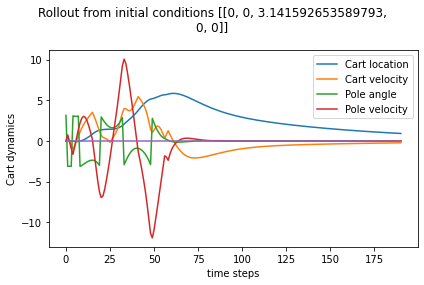

In [254]:
plot_non_lin_policy(five_basis_linear,[[0,0,np.pi,0,0]],5)

In [ ]:
stop

In [104]:
five_basis_works= trial1.copy()
"""
[-0.88627338  0.3843074  -1.76918894  0.53029744 -0.90781458 -0.98418243
 -0.68307035  1.04291954 -0.59176178 -0.70235259 -0.71231297 -0.15859843
 -0.03602326  1.83086973  1.9060143   0.40009059  0.45698007  1.18732843
  0.4036069   0.19993126 -0.96396212  0.63336196  3.13633011 -1.14516308
  3.20452413 -2.31675166  1.57987838 -0.88633965  1.61848164  0.59080514
  1.41278563 -0.03985638 -1.76028072 -1.32137854 -1.36883564]
 """

'\n[-0.88627338  0.3843074  -1.76918894  0.53029744 -0.90781458 -0.98418243\n -0.68307035  1.04291954 -0.59176178 -0.70235259 -0.71231297 -0.15859843\n -0.03602326  1.83086973  1.9060143   0.40009059  0.45698007  1.18732843\n  0.4036069   0.19993126 -0.96396212  0.63336196  3.13633011 -1.14516308\n  3.20452413 -2.31675166  1.57987838 -0.88633965  1.61848164  0.59080514\n  1.41278563 -0.03985638 -1.76028072 -1.32137854 -1.36883564]\n '

In [213]:
five_basis_linear=trial1.copy()
"""
[-3.26529408e-02  6.79817703e-01  5.20024780e-01 -1.06952754e+00
  1.07243194e+00 -7.47804272e-02 -5.00813554e-01  6.51595682e-01
  2.66160759e+00  1.75609963e+00 -1.09060150e+00 -9.89393685e-01
  1.89853130e-02 -8.43092480e-01 -2.88422746e-01  7.42265715e-01
  6.62491484e-03 -2.40667981e-01 -4.44275254e-01 -5.25321649e-01
  1.04163532e+00 -7.49027707e-02  1.32590817e+00 -5.68067509e-01
  6.85328700e-01 -6.02056808e-01  1.33006483e-01  2.43855704e-03
 -3.35963235e-01 -2.07107225e+00  6.02556402e-01  7.75710866e-02
 -4.49910916e-01 -4.20422018e-01 -8.45981997e-01]
 """

'\n[-3.26529408e-02  6.79817703e-01  5.20024780e-01 -1.06952754e+00\n  1.07243194e+00 -7.47804272e-02 -5.00813554e-01  6.51595682e-01\n  2.66160759e+00  1.75609963e+00 -1.09060150e+00 -9.89393685e-01\n  1.89853130e-02 -8.43092480e-01 -2.88422746e-01  7.42265715e-01\n  6.62491484e-03 -2.40667981e-01 -4.44275254e-01 -5.25321649e-01\n  1.04163532e+00 -7.49027707e-02  1.32590817e+00 -5.68067509e-01\n  6.85328700e-01 -6.02056808e-01  1.33006483e-01  2.43855704e-03\n -3.35963235e-01 -2.07107225e+00  6.02556402e-01  7.75710866e-02\n -4.49910916e-01 -4.20422018e-01 -8.45981997e-01]\n '